<a href="https://colab.research.google.com/github/fanfanfuzzy/combo3/blob/master/battery_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clone IBM FM4M github repository

In [ ]:
!git clone https://github.com/IBM/materials.git

In [ ]:
cd materials/examples

### Install packages

In [ ]:
!pip install umap-learn selfies datasets rdkit torch-geometric xgboost torch-nl ase==3.24.0

## Battery Electrolyte Formulation

Improving Performance Prediction of Electrolyte Formulations with Transformer-based Molecular Representation Model

https://arxiv.org/abs/2406.19792

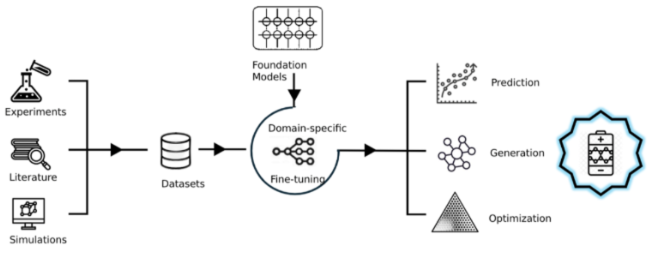

### Import Libraries

In [ ]:
import sys
sys.path.append("../models")
sys.path.append("../")


In [ ]:
import models.fm4m as fm4m
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

### Load Data
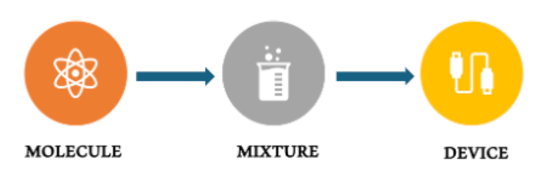

In [ ]:
train_df  = pd.read_csv(f"../data/lce/train.csv").dropna()
test_df  = pd.read_csv(f"../data/lce/test.csv").dropna()

In [ ]:
train_df.head()

In [ ]:
# Make a list of smiles
train_smiles_list = pd.concat([train_df[f'smi{i}'] for i in range(1, 7)]).unique().tolist()
test_smiles_list = pd.concat([test_df[f'smi{i}'] for i in range(1, 7)]).unique().tolist()

### List of available models

In [ ]:
fm4m.avail_models()

### Get embeddings
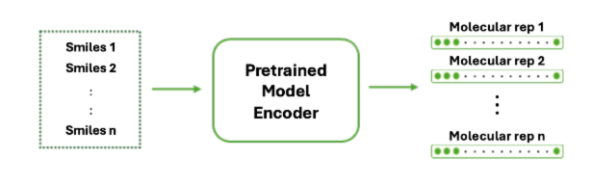

In [ ]:
model_type = "SELFIES-TED"
train_emb, test_emb = fm4m.get_representation(train_smiles_list,test_smiles_list, model_type, return_tensor=False)

In [ ]:
train_emb = [np.nan if row.isna().all() else row.dropna().tolist() for _, row in train_emb.iterrows()]
test_emb = [np.nan if row.isna().all() else row.dropna().tolist() for _, row in test_emb.iterrows()]

In [ ]:
train_dict = dict(zip(train_smiles_list, train_emb))
test_dict = dict(zip(test_smiles_list, test_emb))

In [ ]:
def replace_with_list(value, my_dict):
    return my_dict.get(value, value)

In [ ]:
# Replacement the smiles string with its embeddings
df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))
df_test_emb = test_df.applymap(lambda x: replace_with_list(x, test_dict))

In [ ]:
# Drop rows with NaN and reset index
df_train_emb = df_train_emb.dropna().reset_index(drop=True)
df_test_emb = df_test_emb.dropna().reset_index(drop=True)

In [ ]:
# Display the first few rows of train data
df_train_emb.head()

In [ ]:
# Display the first few rows of test data
df_test_emb.head()

### Construct feature vector for the formulation
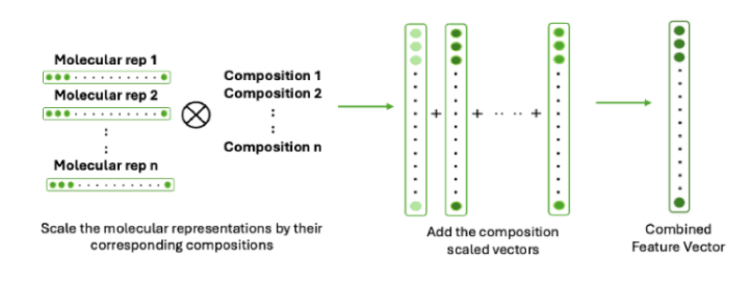

In [ ]:
# Construct feature vector by scaling the representation by their corresponding composition and add
def compute_components(df, smi_cols, conc_cols):
    components = [df[smi].apply(pd.Series).mul(df[conc], axis=0) for smi, conc in zip(smi_cols, conc_cols)]
    return sum(components)

In [ ]:
# List of columns to process
smi_cols = [f'smi{i}' for i in range(1, 7)]
conc_cols = [f'conc{i}' for i in range(1, 7)]

In [ ]:
# Train data processing
x_train = compute_components(df_train_emb, smi_cols, conc_cols)
y_train = pd.DataFrame(df_train_emb["LCE"], columns=["LCE"])

In [ ]:
# Test data processing
X_test = compute_components(df_test_emb, smi_cols, conc_cols)
y_test = pd.DataFrame(df_test_emb["LCE"], columns=["LCE"])

### Downstream Model : SVR Regressor

In [ ]:
regressor = SVR(kernel="rbf", degree=3, C=5, gamma="scale", epsilon=0.01)
model = TransformedTargetRegressor(regressor=regressor,
                                   transformer=MinMaxScaler(feature_range=(-1, 1))
                                   ).fit(x_train, y_train)

In [ ]:
y_prob = model.predict(X_test)
RMSE_score = root_mean_squared_error(y_test, y_prob)
print(RMSE_score)